In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import cv2
from typing import Tuple, Union
import math
import gdown
import mediapipe as mp

# 1. Build Data Loading Functions

### This is used to download the dataset

In [2]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [6]:
# pixels
MARGIN = 0  
# pixels
ROW_SIZE = 0  


FONT_SIZE = 1
FONT_THICKNESS = 1


# red
TEXT_COLOR = (255, 0, 0)  
# Input model Image size
IMAGE_SIZE = (1920,1080)

## Functions

In [7]:
def normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

### new code:

In [1]:
import cv2
import mediapipe as mp

def normalized_to_pixel_coordinates(normalized_x, normalized_y, image_width, image_height):
    """Converts normalized values to pixel coordinates."""
    x_px = min(max(int(normalized_x * image_width), 0), image_width)
    y_px = min(max(int(normalized_y * image_height), 0), image_height)
    return x_px, y_px

cap = cv2.VideoCapture(0)

# Face detector model
mp_face_detection = mp.solutions.face_detection

# Variables for adjusting the bounding box
# You can tweak these variables to adjust the bounding box position and size
horizontal_scale_factor = 1.7  # This widens the box relative to the distance between ears
vertical_scale_factor = 3  # This lengthens the box, you may want to start with 0.6
horizontal_shift_factor = 0.0  # Start with no horizontal shift
vertical_shift_factor = 0.5    # Shift the box down a bit relative to the lips landmark
aspect_ratio = 0.2             # Assuming the mouth area is about 20% as tall as it is wide



with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("Broken image")
            continue

        # Convert to RGB        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Get the keypoints of each point of a face in the frame
        results = face_detection.process(frame_rgb)
        
        if results.detections:
            for detection in results.detections:
                location = detection.location_data
                image_rows, image_cols, _ = frame.shape

                # Assuming the landmarks are correctly indexed
                try:
                    # Landmarks
                    left_ear = location.relative_keypoints[0]  # Index for left ear
                    right_ear = location.relative_keypoints[1]  # Index for right ear
                    lips = location.relative_keypoints[2]  # Index for lips, you need to find the correct index

                    # Width of the box (dynamic based on face width)
                    box_width = int(abs(right_ear.x - left_ear.x) * horizontal_scale_factor * image_cols)

                    # Height of the box (maintain aspect ratio)
                    box_height = int(box_width * aspect_ratio * vertical_scale_factor)

                    # Center of the box, adjusted by shift factors
                    box_center_x, box_center_y = normalized_to_pixel_coordinates(
                        lips.x + horizontal_shift_factor * (right_ear.x - left_ear.x),
                        lips.y + vertical_shift_factor * (box_height / image_rows),
                        image_cols, image_rows
                    )

                    # Calculate start and end points of the rectangle
                    rect_start_point = (box_center_x - box_width // 2, 
                                        box_center_y - box_height // 2)

                    rect_end_point = (box_center_x + box_width // 2, 
                                      box_center_y + box_height // 2)

                    # Draw the rectangle around the lips
                    cv2.rectangle(frame, rect_start_point, rect_end_point, (0, 255, 0), 2)

                except IndexError:
                    # Handle the case where the landmarks are not found
                    print("Error: Facial landmarks not found")

        # Display the frame
        cv2.imshow('frame', frame) 
        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

: 

### old code: 

In [1]:
cap = cv2.VideoCapture(0)

# face detector model
mp_face_detection = mp.solutions.face_detection

# frames of the video
frames = []


while True:
    ret, frame = cap.read()

    if( not ret):
        print("broke image")
        continue

    with mp_face_detection.FaceDetection(
        model_selection=2, min_detection_confidence=1) as face_detection:
        
    # loop over all frames in the video
    # for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 

       

        # convert to rgb        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # get the keypoints (x,y)s of each point of a face in the frame
        results = face_detection.process(frame)
        
        
        # loop over each face landmark ~ (nose (x,y) lips (x,y) and so one and a bounding box)
        if results.detections:
            for detection in results.detections:

                location = detection.location_data
                
                image_rows, image_cols, _ = frame.shape

                # print(detection) to know what is the object your dealing with
                ###################

                # Hani i want your to change the below, use the left, right and nose positions
                # to choose a boudning box around the lips, with the help of thier x,y
                # so that no matter the subject is far away from the camera or near, you can
                # get a decent box around the lips and not a constant size

                # advise: right it down mathematically and then do it in code

                ###################
                # -3 is the lips and -1 and -2 are the left and right ears i think
                relative_bounding_box = location.relative_keypoints[-3]
                

                # all x, y are in percentage of frame width and hieght
                # we use the below function to make them in x,y positions in pixels not percentage
                
                rect_start_point = normalized_to_pixel_coordinates(
                relative_bounding_box.x*0.8, relative_bounding_box.y*0.9, image_cols,
                image_rows)

                
                rect_end_point = normalized_to_pixel_coordinates(
                relative_bounding_box.x*1.2,
                relative_bounding_box.y*1.1, image_cols,
                image_rows)


                ### below draws the rectangle and points

                cv2.rectangle(frame, rect_start_point, rect_end_point,
                (0,0,0), 2)
                keypoint_px = normalized_to_pixel_coordinates(relative_bounding_box.x, relative_bounding_box.y,
                                                        image_cols, image_rows)
                cv2.circle(frame, keypoint_px, 2,
                    (255,0,0), 2)
                cv2.circle(frame, rect_start_point, 2,
                (255,0,255), 2)
                cv2.circle(frame, rect_end_point, 2,
                (255,255,0), 2)

            # crop only the lip part from the boudning box
            # frame = frame[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],:]

            # resize
            # frame = cv2.resize(frame, IMAGE_SIZE, interpolation = cv2.INTER_AREA)

            # grayscale
        # frame = tf.image.rgb_to_grayscale(frame)
    print(frame.shape)
    cv2.imshow('frame', frame) 
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break


cap.release()
cv2.destroyAllWindows()
    

#     # standard normalization
#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
# return tf.cast((frames - mean), tf.float32) / std

NameError: name 'cv2' is not defined

In [6]:
load_video("bbaf2n.mpg")


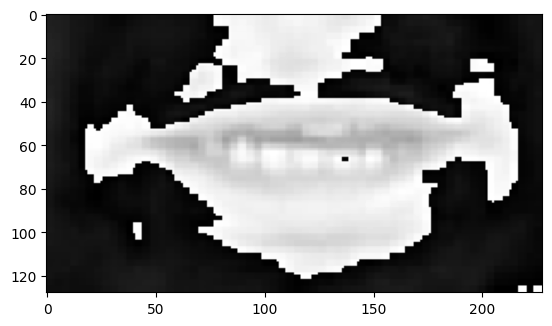

In [153]:
plt.imshow(buf[50,:,:,:],cmap='gray')

In [6]:
def load_video_mohamed_save_for_later(path:str) -> List[float]: 

    # opens the video's path as a camera object
    cap = cv2.VideoCapture(path)

    # face detector model
    mp_face_detection = mp.solutions.face_detection

    # frames of the video
    frames = []
    
    
    
    with mp_face_detection.FaceDetection(
      model_selection=2, min_detection_confidence=1) as face_detection:
      
        # loop over all frames in the video
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
            ret, frame = cap.read()
            frame.flags.writeable = False
    
            # convert to rgb        
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # get the keypoints (x,y)s of each point of a face in the frame
            results = face_detection.process(frame)

            # idk wtf this does
            frame.flags.writeable = True
            
            
            # loop over each face landmark ~ (nose (x,y) lips (x,y) and so one and a bounding box)
            if results.detections:
                for detection in results.detections:

                    location = detection.location_data
                    
                    image_rows, image_cols, _ = frame.shape

                    # -3 is the lips and -1 and -2 are the left and right ears i think
                    relative_bounding_box = location.relative_keypoints[-3]
                    

                    # all x, y are in percentage of frame width and hieght
                    # we use the below function to make them in x,y positions in pixels not percentage
                    
                    rect_start_point = normalized_to_pixel_coordinates(
                    relative_bounding_box.x*0.8, relative_bounding_box.y*0.9, image_cols,
                    image_rows)

                    
                    rect_end_point = normalized_to_pixel_coordinates(
                    relative_bounding_box.x*1.2,
                    relative_bounding_box.y*1.1, image_cols,
                    image_rows)


                    ### below draws the rectangle and points

                    # cv2.rectangle(frame, rect_start_point, rect_end_point,
                    # (0,0,0), 2)
                    # keypoint_px = normalized_to_pixel_coordinates(relative_bounding_box.x, relative_bounding_box.y,
                    #                                         image_cols, image_rows)
                    # cv2.circle(frame, keypoint_px, 2,
                    #     (255,0,0), 2)
                    # cv2.circle(frame, rect_start_point, 2,
                    # (255,0,255), 2)
                    # cv2.circle(frame, rect_end_point, 2,
                    # (255,255,0), 2)

            # crop only the lip part from the boudning box
            frame = frame[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],:]

            # resize
            frame = cv2.resize(frame, IMAGE_SIZE, interpolation = cv2.INTER_AREA)

            # grayscale
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame)
        cap.release()
        cv2.waitKey(0)

        # standard normalization
        mean = tf.math.reduce_mean(frames)
        std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [154]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [155]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [156]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [158]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [159]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [225]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [226]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s11','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','s11','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [227]:
test_path = 'data\s11\s1\\bbaf2n.mpg'

In [228]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [229]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


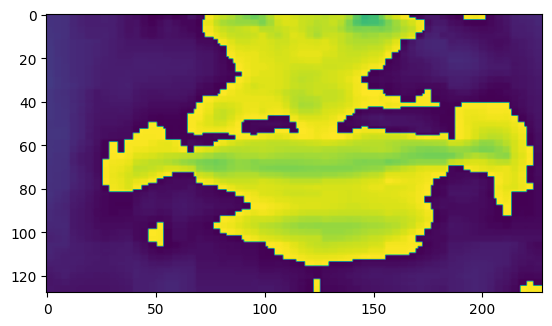

In [236]:
plt.imshow(frames[0])

In [237]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [238]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [239]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [240]:
from matplotlib import pyplot as plt

In [258]:
data = tf.data.Dataset.list_files('./data/s11/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [261]:
len(train)

450

In [260]:
len(test)

50

In [243]:
frames, alignments = data.as_numpy_iterator().next()

In [254]:
frames[0].shape

(75, 128, 228, 1)

In [262]:
sample = data.as_numpy_iterator()

In [278]:
val = sample.next()

val[1][0].shape,val[0][0].shape

((40,), (75, 128, 228, 1))

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e two please'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
5*17*75

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'444iiiiiiiiiiiiiimmmmmmmmmmmmmmmmmmmmmmiiiiiiiiiiimmmmmmmmiiiiiiiiiiixxxxxx'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'444iiiiiiiiiiiiiimmmmmmmmmmmmmmmmmmmmmmiiiiiiiiiiimmmmmmmmiiiiiiiiiiixxxxxx'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 3:03 - loss: 213.9969 


KeyboardInterrupt



# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]